# 2.1 Realizácia predspracovania dát (5b).

### (A-1b) Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len **s trénovacím datasetom**.


In [268]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
folder = Path("./070")

### Dáta si načítame

In [269]:
connections_df = pd.read_csv(folder / "connections.csv", delimiter="\t", parse_dates=['ts'])
devices_df = pd.read_csv(folder / "devices.csv", delimiter="\t")
processes_df = pd.read_csv(folder / "processes.csv", delimiter="\t", parse_dates=['ts'])
profiles_df = pd.read_csv(folder / "profiles.csv", delimiter="\t")

## Zlúčenie dát z rôznych tabuliek

Tabuľky majú spoločný atribút, a tým je **imei**, ten ale nie je unikátny, a tak potrebujeme ďalší atribút na spojenie tabuľky. Unikátny kľúč, podľa ktorého by sme mohli tabuľky spojiť, je **imei + datetime + mwra**. Ak spojím tabuľky na základe týchto atribútov, dostaneme **validný merge**. Tieto dáta avšak nájdeme iba v datesetoch **connections.csv** a **processes.csv**, preto spojíme iba tieto tabuľky.

Dáta rozdelíme pomocou funkcie **train_test_split()** z sklearn.model v pomere $80$:$20$. **random_state** zaisťuje opakovateľnosť, aby sme mohli prípadne debuggovať.

In [270]:
merged_data = pd.merge(connections_df, processes_df, on=['imei', 'ts', 'mwra'], how='inner')

# este rozdelime cas na konkretne atributy, aby
# sme ich pripadne mohli pouzit v ML

# merged_data['year'] = merged_data['ts'].dt.year
# merged_data['month'] = merged_data['ts'].dt.month
# merged_data['day'] = merged_data['ts'].dt.day
# merged_data['hour'] = merged_data['ts'].dt.hour
# merged_data['day_of_week'] = merged_data['ts'].dt.dayofweek

# tieto data sme sa rozhodli nepridavat (vid 2.2 A))



print(merged_data.shape)
merged_data.head()


# potom splitnut merged data na 80 % trainning a 20% testing pomocou train_test_split
merged_train_df, merged_test_df = train_test_split(merged_data, test_size=0.2, random_state=42)


(15426, 33)


In [271]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12340 entries, 3784 to 7270
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          12340 non-null  datetime64[ns]
 1   imei                        12340 non-null  int64         
 2   mwra                        12340 non-null  float64       
 3   c.android.youtube           12340 non-null  float64       
 4   c.katana                    12340 non-null  float64       
 5   c.dogalize                  12340 non-null  float64       
 6   c.android.chrome            12340 non-null  float64       
 7   c.android.gm                12340 non-null  float64       
 8   c.UCMobile.x86              12340 non-null  float64       
 9   c.raider                    12340 non-null  float64       
 10  c.android.vending           12340 non-null  float64       
 11  c.updateassist              12340 non-null  float64      

In [272]:
merged_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3086 entries, 2183 to 3859
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          3086 non-null   datetime64[ns]
 1   imei                        3086 non-null   int64         
 2   mwra                        3086 non-null   float64       
 3   c.android.youtube           3086 non-null   float64       
 4   c.katana                    3086 non-null   float64       
 5   c.dogalize                  3086 non-null   float64       
 6   c.android.chrome            3086 non-null   float64       
 7   c.android.gm                3086 non-null   float64       
 8   c.UCMobile.x86              3086 non-null   float64       
 9   c.raider                    3086 non-null   float64       
 10  c.android.vending           3086 non-null   float64       
 11  c.updateassist              3086 non-null   float64       

### (B-1b) Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok. 


## Ako prvé si v mergnutom datasete určíme správne dátove typy

In [273]:
# function to find out mixed values in a column
def check_mixed_types(df):
    for column in df.columns:
        unique_types = df[column].apply(type).unique()
        if len(unique_types) > 1:
            print(f'Column: {column} has mixed types: {unique_types}')
        else:
            print(f'Column: {column} has only one type: {unique_types}')

check_mixed_types(merged_train_df)

Column: ts has only one type: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
Column: imei has only one type: [<class 'int'>]
Column: mwra has only one type: [<class 'float'>]
Column: c.android.youtube has only one type: [<class 'float'>]
Column: c.katana has only one type: [<class 'float'>]
Column: c.dogalize has only one type: [<class 'float'>]
Column: c.android.chrome has only one type: [<class 'float'>]
Column: c.android.gm has only one type: [<class 'float'>]
Column: c.UCMobile.x86 has only one type: [<class 'float'>]
Column: c.raider has only one type: [<class 'float'>]
Column: c.android.vending has only one type: [<class 'float'>]
Column: c.updateassist has only one type: [<class 'float'>]
Column: c.UCMobile.intl has only one type: [<class 'float'>]
Column: p.android.chrome has only one type: [<class 'float'>]
Column: p.android.documentsui has only one type: [<class 'float'>]
Column: p.android.packageinstaller has only one type: [<class 'float'>]
Column: p.android.settings 

Vo výpise vidíme, že dátové typy sú **určené správne** a taktiež sú v **jednotnom formáte**.

## Identifikujeme a vyriešime (odstránime) duplikáty

In [318]:
def remove_duplicates(df):
    # v datasetoch sa nevyskytol prípad, kde by bol duplikátny sĺpec, a preto tu riešime iba riadky

    df_dupless = df

    if len(df.loc[df.duplicated(), :]) > 0:
        df_dupless = df.loc[~df.duplicated(), :]
    
    return df_dupless

In [275]:
merged_train_df = remove_duplicates(merged_train_df)

## Identifikujeme a vyriešime chýbajúce hodnoty

In [276]:
def has_missing_values(df):
    return df.isnull().any().any()


def count_missing_values(col):
    return col.isna().sum()


def replace_missing_values(col):
    # lets calculate the amount of outliers to determine, whether to use mean or median

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    # lets identify the outliers
    outliers = ((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))
    outliers_percentage = (outliers.sum() / col.count()) * 100

    if outliers_percentage < 5:
        return col.fillna(col.mean)
    else:
        return col.fillna(col.median)


def solve_missing_values(df):
    # if missing values < 5% => clip
    # if missing values >= 5% => replace with median
    # if missing values > 40% => drop column

    if not has_missing_values(df):
        print("there are no missing values")
        return df
    else:
        for column in df:
            total_rows = len(df)
            na_amount = count_missing_values(df[column])
            na_percentage = (na_amount/total_rows) * 100
            print(f'percentage: {column}: {na_percentage}%')

            # the missing values are making smaller amount than 5% so we clip them
            if na_percentage < 5:
                df = df.dropna(subset=[column])
            # the missing values will be replaced
            elif na_percentage >= 5 and na_percentage <= 40:
                df[column] = replace_missing_values(df[column])
            # there is too much missing values, lets drop the column
            else:
                df.drop(column, axis=1, inplace=True)
                print(f'dropped: {column}')
    return df


In [277]:
merged_train_df = solve_missing_values(merged_train_df)

there are no missing values


In [278]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]


def print_outliers_stat(df):
    for column in df:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            outliers = identify_outliers(df[column])
            print(f'{column}: {len(outliers)} => {(len(outliers) * 100) / len(df[column]):.2f}%')


def remove_outliers(df):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['number']).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    return df_cleaned


def replace_outliers(df):
    # replace outliers with bounds, mean or median
    df_replaced = df.copy()

    for column in df_replaced.select_dtypes(include=['number']).columns:
        Q1 = df_replaced[column].quantile(0.25)
        Q3 = df_replaced[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # replace with mean
        # mean = df_replaced[column].mean()
        # df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])
        # df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])

        # replace with median
        median = df_replaced[column].median()
        df_replaced[column] = np.where(df_replaced[column] > upper_bound, median, df_replaced[column])
        df_replaced[column] = np.where(df_replaced[column] > upper_bound, median, df_replaced[column])

        # replace with bounds
        #df_replaced[column] = np.where(df_replaced[column] > upper_bound, upper_bound, df_replaced[column])
        #df_replaced[column] = np.where(df_replaced[column] < lower_bound, lower_bound, df_replaced[column])

    return df_replaced


def solve_outliers(df):
    # najskor spravime iteraciu kedy nahradine outlierov medianom
    # a potom iteraciu clipnutia
    df = replace_outliers(df)
    df = remove_outliers(df)
    # print_outliers_stat(df)
    return df

In [279]:
merged_train_df = solve_outliers(merged_train_df)

## Kódovanie kategórií do numerického formátu

Na enkódovanie kategórií by sme použili LabelEncoder pre atribúty s malým počtom kategórií a OneHotEncoder pre viacero kategórií. Naše mergnuté data sú už všetky atriúty numerické, takže toto netreba riešit v našom prípade.

In [280]:
merged_train_df.head()

,ts,imei,mwra,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.gm,c.UCMobile.x86,c.raider,...,p.katana,p.google,p.notifier,p.android.defcontainer,p.android.vending,p.inputmethod.latin,p.simulator,p.olauncher,p.browser.provider,p.gms.persistent
3784,2018-05-08 00:16:00,3.590434e+18,1.0,15.75402,11.35425,12.69769,13.98911,18.44522,36.33887,94.21625,...,61.30390,45.88740,45.15843,54.34515,29.70903,71.06763,44.12748,40.57806,86.56577,36.08712
13811,2018-05-14 21:32:00,8.630331e+18,0.0,17.83548,12.68519,12.33846,9.23900,11.54725,72.95152,46.56260,...,53.09412,36.06125,37.92394,92.71656,4.49703,46.40346,10.95631,54.73916,29.11742,67.40191
3128,2018-05-07 13:27:00,3.590434e+18,0.0,15.78895,9.66345,14.13034,11.18431,10.11198,50.86418,85.80315,...,68.17441,60.84868,43.79665,30.91028,1.84816,36.52292,8.24216,85.18883,33.75441,64.96796
9054,2018-05-11 15:05:00,8.630331e+17,1.0,11.37649,10.19282,11.05887,11.76303,14.81542,65.66696,53.12155,...,42.43496,64.32815,62.33747,59.09491,58.34689,52.63315,9.23062,24.73049,98.90116,27.37353
6556,2018-05-09 21:53:00,3.590434e+18,1.0,17.95142,14.08414,14.14630,12.76846,10.78588,52.00460,17.08141,...,67.82886,57.03509,32.46436,97.35878,91.75350,56.85502,31.26979,52.26952,34.74844,42.78789


<Axes: >

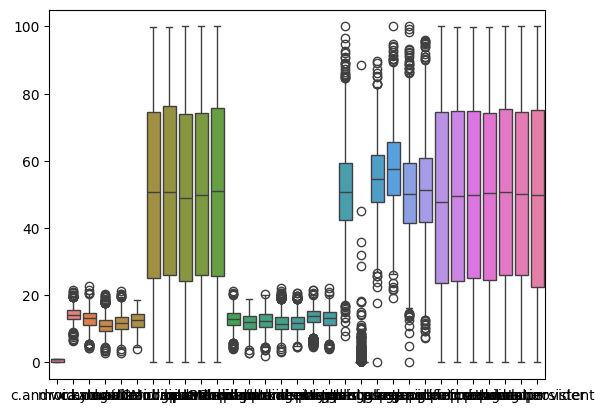

In [281]:
sns.boxplot(data=merged_test_df.drop('imei', axis=1))

## Merged data
Na merged dátach vidíme, že sú všetky atribúty numerické, a tak ich môžme všetky použiť v ML.

### (C-2b) Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze). 

# Import
Importujeme potrebné knižnice

In [282]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as pyplot

# Save mwra
Predtým ako budeme škálovať dáta si odložíme našu predikovanú hodnotu mwra a v mergnutom datasete ju dropneme.

In [283]:
saved_mwra = merged_train_df['mwra'].reset_index(drop=True)
merged_train_with_mwra = merged_train_df
merged_train_df = merged_train_df.drop(['mwra'], axis=1)

In [284]:
# we will be using these 2 scalers and 2 transformers and we will create 4 combinations
scaler_standard = StandardScaler()
scaler_min_max = MinMaxScaler()
power_transformer = PowerTransformer()
quantile_transformer = QuantileTransformer()

- **StandardScaler** štandardizuje atribúty tak, že ich prevedie na distribúciu s priemerom 0 a štandardnou odchýlkou 1.
- **MinMaxScaler** škáluje atribúty do zvoleného rozsahu (napríklad 0 až 1)
- **PowerTransformer** využíva Box-Cox alebo Yeo-Johnson transformáciu na stabilizáciu rozdelenia.
- **QuantileTransformer** prevedie distribúciu dát na približne normálnu distribúciu pomocou kvantilov.

# 1. kombinácia škálovania a transformácie

In [285]:
# Transformujeme a škálujeme numerické dáta
sp_data = merged_train_df.select_dtypes(include=[np.number]).copy()
sp_data = power_transformer.fit_transform(sp_data)
sp_data = scaler_standard.fit_transform(sp_data)
sp_data = pd.DataFrame(sp_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# Resetujeme index transformovaných dát pre konzistenciu
sp_data = sp_data.reset_index(drop=True)

# Pridame uložený stĺpec mwra späť do dátového rámca
sp_data['mwra'] = saved_mwra


/Users/filipzubaj/Desktop/School/IAU/iau_projekt/iau_project/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


# 2. kombinácia škálovania a transformácie

In [286]:
# sq stands for standard scaler and quantile transformer
sq_data = merged_train_df.select_dtypes(include=[np.number]).copy()
sq_data = quantile_transformer.fit_transform(sq_data)
sq_data = scaler_standard.fit_transform(sq_data)
sq_data = pd.DataFrame(sq_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# Resetujeme index transformovaných dát pre konzistenciu
sq_data = sq_data.reset_index(drop=True)

# Pridame uložený stĺpec mwra späť do dátového rámca
sq_data['mwra'] = saved_mwra

# 3. kombinácia škálovania a transformácie

In [287]:
# mp stands for min max scaler and power transformer
mp_data = merged_train_df.select_dtypes(include=[np.number]).copy()
mp_data = power_transformer.fit_transform(mp_data)
mp_data = scaler_min_max.fit_transform(mp_data)
mp_data = pd.DataFrame(mp_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# Resetujeme index transformovaných dát pre konzistenciu
mp_data = mp_data.reset_index(drop=True)

# Pridame uložený stĺpec mwra späť do dátového rámca
mp_data['mwra'] = saved_mwra

/Users/filipzubaj/Desktop/School/IAU/iau_projekt/iau_project/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


# 4. kombinácia škálovania a transformácie

In [288]:
# mq stands for min max scaler and quantile transformer
mq_data = merged_train_df.select_dtypes(include=[np.number]).copy()
mq_data = quantile_transformer.fit_transform(mq_data)
mq_data = scaler_min_max.fit_transform(mq_data)
mq_data = pd.DataFrame(mq_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# Resetujeme index transformovaných dát pre konzistenciu
mq_data = mq_data.reset_index(drop=True)

# Pridame uložený stĺpec mwra späť do dátového rámca
mq_data['mwra'] = saved_mwra

<function matplotlib.pyplot.show(close=None, block=None)>

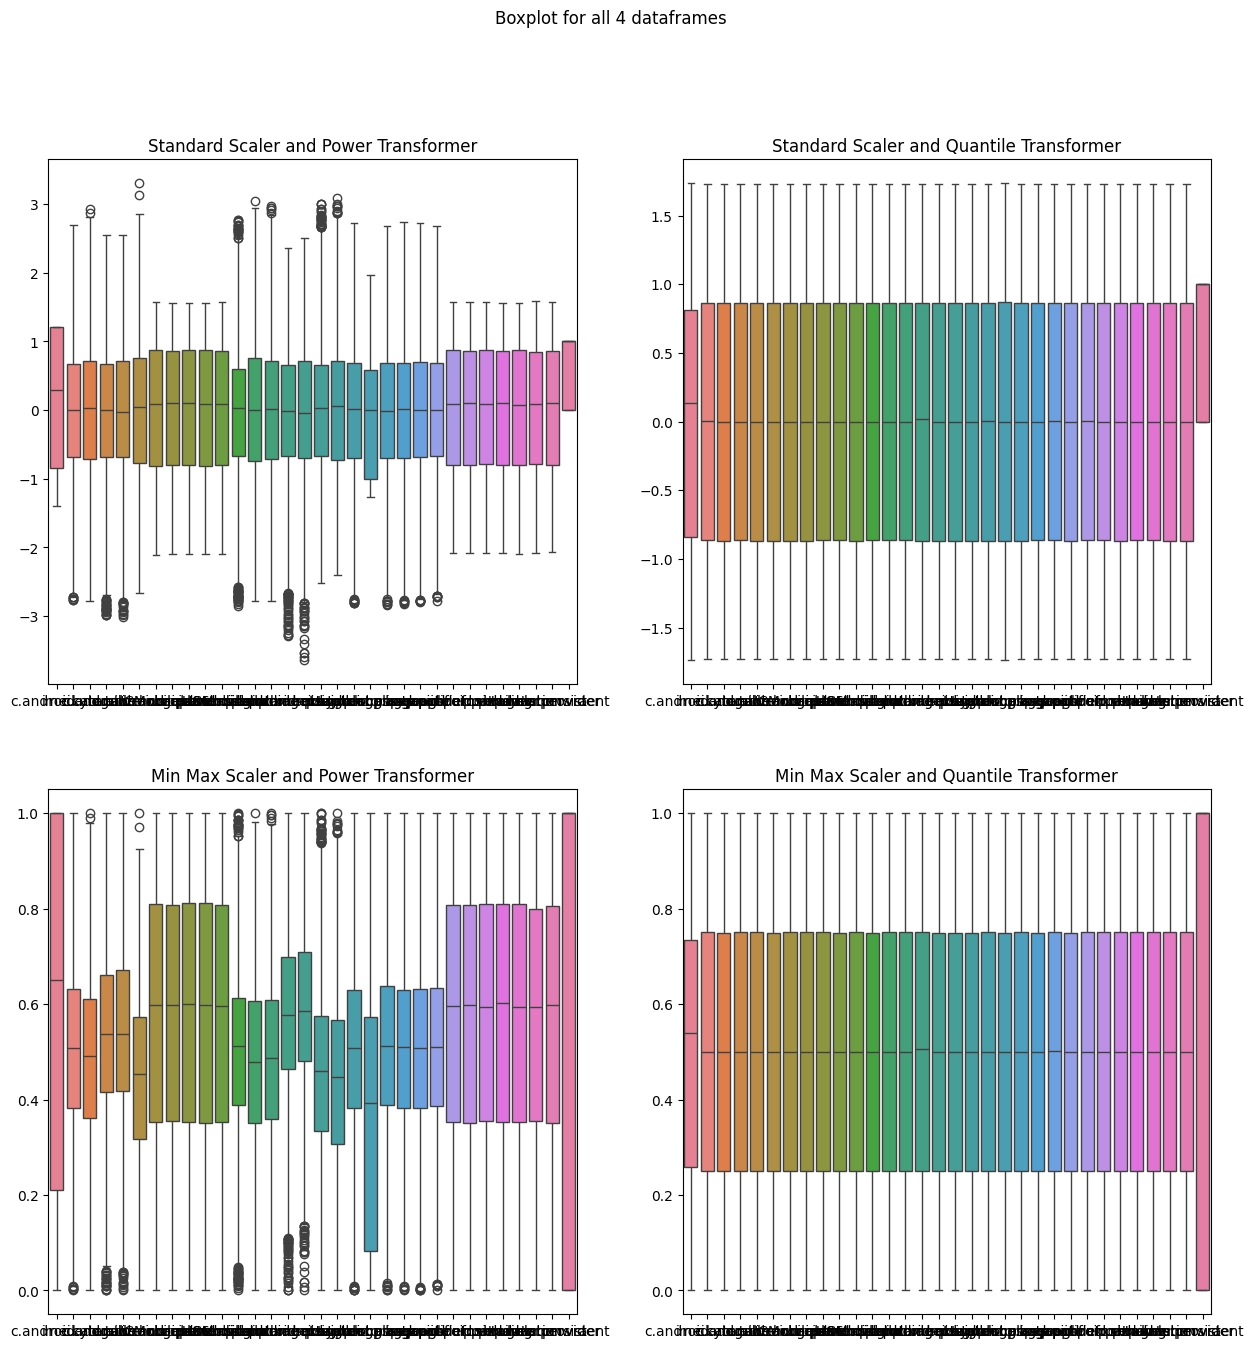

In [289]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Boxplot for all 4 dataframes')

sns.boxplot(data=sp_data, ax=axs[0,0])
axs[0, 0].set_title('Standard Scaler and Power Transformer')

sns.boxplot(data=sq_data, ax=axs[0,1])
axs[0, 1].set_title('Standard Scaler and Quantile Transformer')

sns.boxplot(data=mp_data, ax=axs[1,0])
axs[1,0].set_title('Min Max Scaler and Power Transformer')

sns.boxplot(data=mq_data, ax=axs[1,1])
axs[1,1].set_title('Min Max Scaler and Quantile Transformer')

plt.show

### (D-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)



# !!!!!! TODO !!!!!! TOTO ESTE SKONTROLOVAT A PREJST/PREPISAT

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Transformácii Atribútov

Pri transformácii dát pre strojové učenie je dôležité zabezpečiť, aby atribúty mali vhodnú škálu, boli stabilné a aby ich distribúcia vyhovovala potrebám modelov. Nižšie je uvedené zdôvodnenie zvolených techník transformácie a škálovania.

## 1. Scaling (Škálovanie)
Výber techník škálovania bol motivovaný snahou o optimalizáciu výkonnosti modelov, ktoré často očakávajú normalizované alebo štandardizované vstupy.

### 1.1 StandardScaler
- **Dôvod**: StandardScaler bol zvolený, pretože štandardizuje atribúty na priemer 0 a štandardnú odchýlku 1, čo je vhodné pre algoritmy citlivé na rozsah dát, ako sú SVM, k-means alebo lineárna regresia.
- **Výhoda**: Táto metóda udržuje štatistickú vlastnosť rozdelenia dát a dobre funguje pre dáta, ktoré už majú približne normálne rozdelenie.

### 1.2 MinMaxScaler
- **Dôvod**: MinMaxScaler bol vybraný pre prípady, kde bolo nutné previesť dáta do jednotného rozsahu, napríklad 0 až 1, čo je dôležité pri metódach, ako sú neurónové siete, kde normalizácia atribútov zlepšuje konvergenciu.
- **Výhoda**: Škálovanie do konkrétneho rozsahu môže zvýšiť robustnosť algoritmu voči outlierom a zlepšiť interpretovateľnosť hodnoty každého atribútu.

## 2. Transformers (Transformácie)
Transformácie sme zvolili na stabilizáciu rozdelenia dát a odstránenie šikmosti (skewness), aby sa modely mohli lepšie zamerať na relevantné vzory.

### 2.1 PowerTransformer
- **Dôvod**: PowerTransformer bol zvolený pre svoje schopnosti stabilizovať rozdelenie dát pomocou Yeo-Johnson transformácie. Táto transformácia sa odporúča, ak sú atribúty pozitívne aj negatívne, pričom transformácia stabilizuje šikmosť a robí rozdelenie viac normálnym.
- **Výhoda**: Zlepšenie normality môže pomôcť modelom lineárneho typu a optimalizáciám, ktoré sa opierajú o normálne rozdelenie dát, ako sú regresné modely a PCA.

### 2.2 QuantileTransformer
- **Dôvod**: QuantileTransformer bol zvolený pre svoju schopnosť transformovať rozdelenie dát na normálnu distribúciu bez ohľadu na pôvodné rozdelenie, čo je užitočné pri atribútoch s výraznými odchýlkami.
- **Výhoda**: Táto metóda môže efektívne normalizovať dátové body a je vhodná pre modely citlivé na rozdelenie dát, ako sú algoritmy KNN alebo Bayesovské modely.

## Celkové zdôvodnenie
Tieto voľby boli zamerané na optimalizáciu dát pre rôzne modely strojového učenia, od lineárnych metód po algoritmy citlivé na rozsah a rozdelenie dát. Skúmanie viacerých techník nám umožňuje prispôsobiť transformáciu atribútov tak, aby maximalizovala výkonnosť a presnosť modelu, čo je cieľom tejto fázy prípravy dát.


## 2.2 Výber atribútov pre strojové učenie (5b)

- (A-3b) Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou). 


In [290]:
# definovanie funkcie na porovnanie vysledkov
# spájanie výsledkov do jedného DataFrame
def get_importance_df(X, corr_matrix, rf_model, selector):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'correlation_score': corr_matrix['mwra'].abs().drop('mwra').values,  # Korelácia s cieľovou premennou
        'random_forest_importance': rf_model.feature_importances_,  # Významnosť podľa Random Forest
        'selectkbest_score': selector.scores_  # Významnosť podľa SelectKBest
    })

    # Normalizácia skóre na jednotnú mierku
    importance_df['correlation_score'] = importance_df['correlation_score'] / importance_df['correlation_score'].max()
    importance_df['random_forest_importance'] = importance_df['random_forest_importance'] / importance_df['random_forest_importance'].max()
    importance_df['selectkbest_score'] = importance_df['selectkbest_score'] / importance_df['selectkbest_score'].max()

    # Priemerné skóre ako vážená dôležitosť atribútu
    importance_df['average_importance'] = importance_df[['correlation_score', 'random_forest_importance', 'selectkbest_score']].mean(axis=1)

    return importance_df

# 1. dataframe SP

# 1. technika Korelačná matica pre dataframe č. 1
Korelačná matica identifikuje silu vzťahu medzi každým atribútom a cieľovou premennou. Pre číselné atribúty sa často využíva Pearsonova korelácia; vysoká hodnota (kladná alebo záporná) naznačuje informatívnosť atribútu pre predikciu.

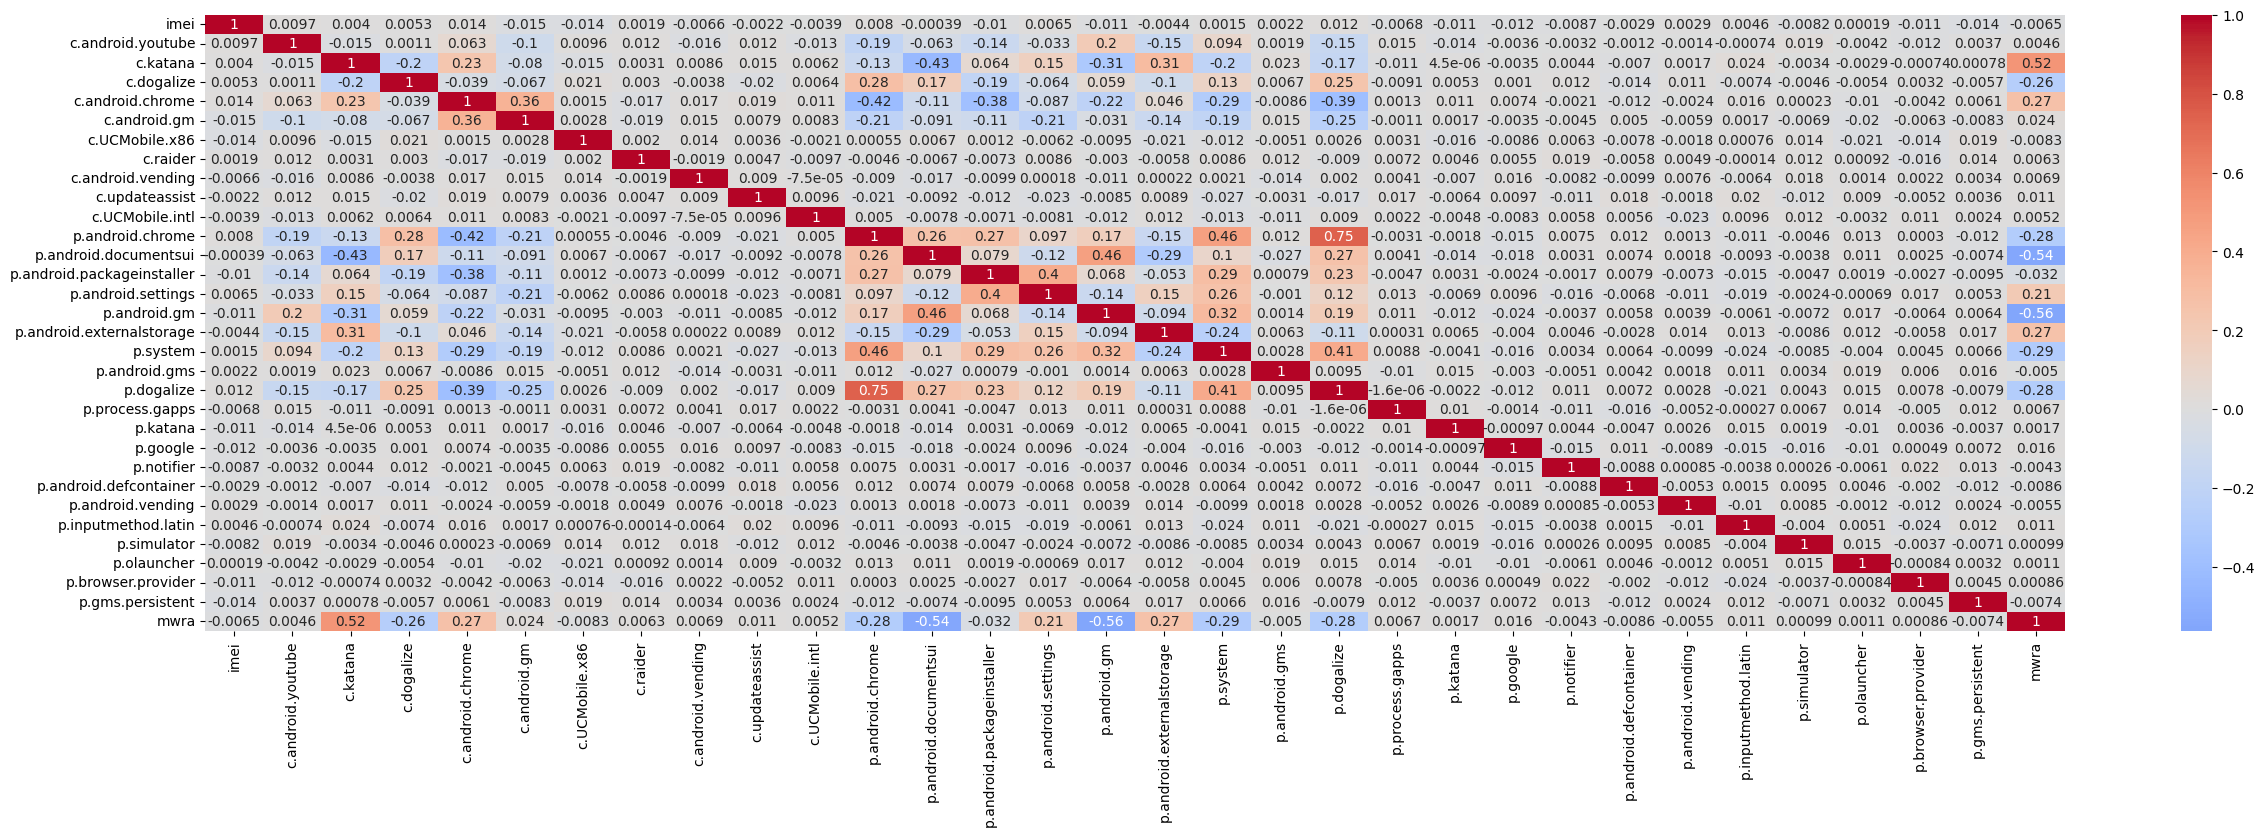

In [291]:
# we will use correlation matrix to identify the relationship between the features and the target variable mwra
# use it for the 4 dataframes

# Vytvorenie korelačnej matice
correlation_matrix = sp_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

korelacna matica je velmi velka, neprehladna a tazko citatelna, preto si vyberieme top 5 najvyssich hodnot k predikovanej premennej mwra

In [292]:
# Výber korelácie pre cieľový stĺpec mwra a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie mwra zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

p.android.gm            -0.561503
p.android.documentsui   -0.544088
c.katana                 0.516967
p.system                -0.289418
p.android.chrome        -0.280080
Name: mwra, dtype: float64


vysledok korelacnej matice mozme vidiet top 5 atributov ktore pravdepodobne vplyvaju na atribut mwra

# 2. technika Random Forest č.1
Použitím modelu Random Forest môžeme zistiť význam atribútov podľa toho, ako často a s akým dopadom sa daný atribút používa pri delení uzlov v rozhodovacích stromoch.

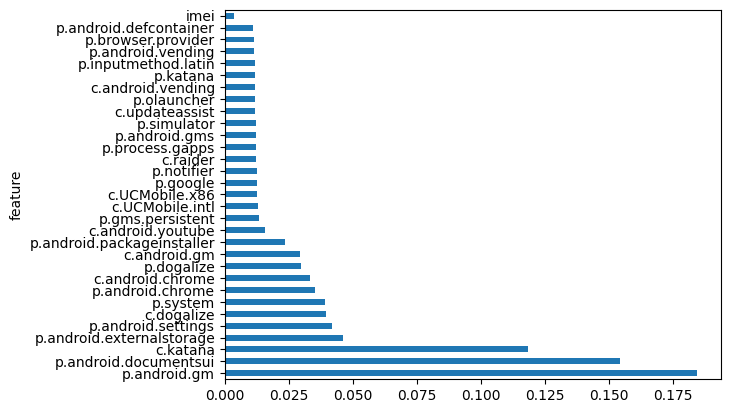

In [293]:
from sklearn.ensemble import RandomForestClassifier

# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = sp_data.drop('mwra', axis=1)
y = sp_data['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

Vysledok random forest mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

# 3. technika selektívne metóda s ANOVA č.1
SelectKBest vyberá atribúty podľa štatistických testov. Pre klasifikačné úlohy sa často používa ANOVA alebo Chi-Square (Chi2) test. Táto metóda umožňuje identifikovať atribúty s najvyššou variabilitou voči cieľovej premennej. My pouzijeme Anovu pretoze mame numericke atributy, chi by sme pouzili pri kategorickych

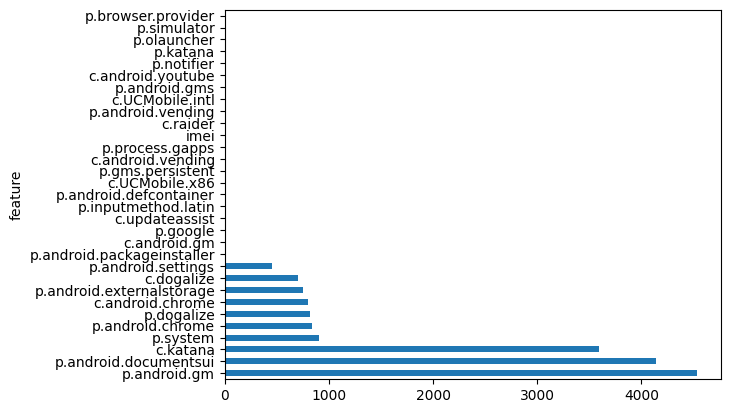

In [294]:
from sklearn.feature_selection import SelectKBest, f_classif

# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

Vysledok ANOVY mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

In [295]:
importance_sp_df = get_importance_df(X, correlation_matrix, rf_model, selector)

# 2. dataframe SQ

# 1. technika Korelačná matica pre dataframe č. 2

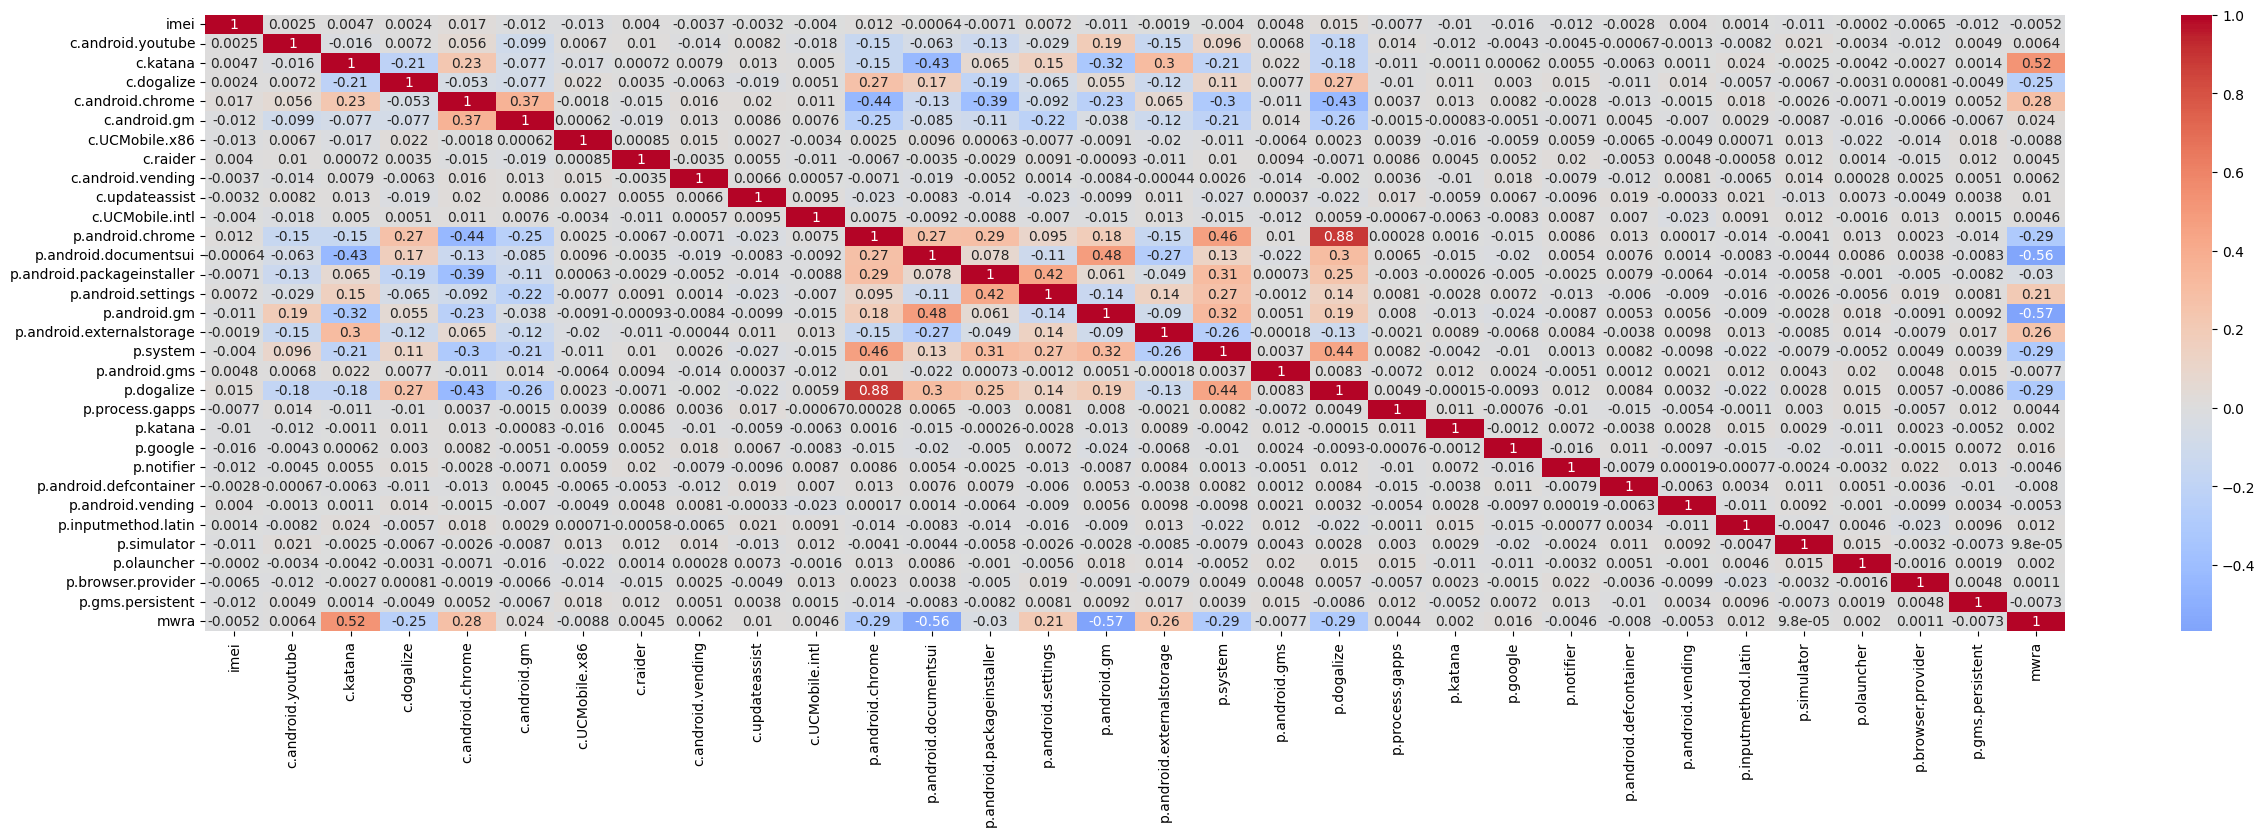

In [296]:
# we will use correlation matrix to identify the relationship between the features and the target variable mwra
# use it for the 4 dataframes

# Vytvorenie korelačnej matice
correlation_matrix = sq_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [297]:
# Výber korelácie pre cieľový stĺpec mwra a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie mwra zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

p.android.gm            -0.567521
p.android.documentsui   -0.559114
c.katana                 0.523234
p.dogalize              -0.293160
p.android.chrome        -0.292400
Name: mwra, dtype: float64


# 2. technika Random Forest č.2

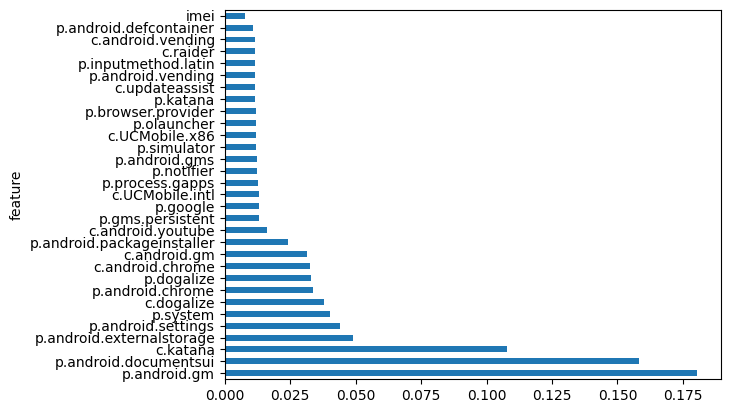

In [298]:
# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = sq_data.drop('mwra', axis=1)
y = sq_data['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

# 3. technika selektívne metóda s ANOVA č.2

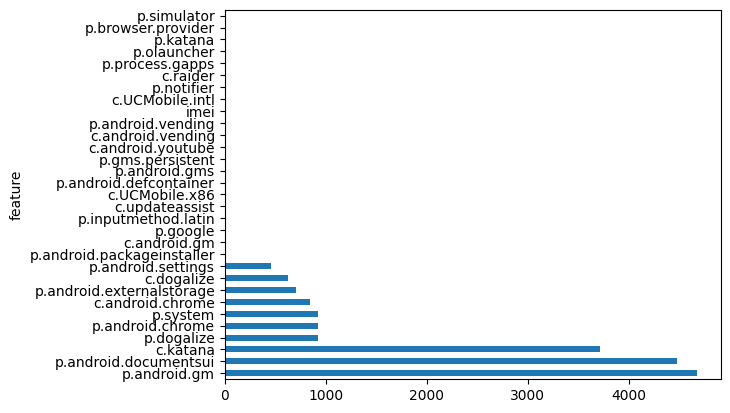

In [299]:
# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

In [300]:
importance_sq_df = get_importance_df(X, correlation_matrix, rf_model, selector)

# 3. dataframe MP

# 1. technika Korelačná matica pre dataframe č. 3

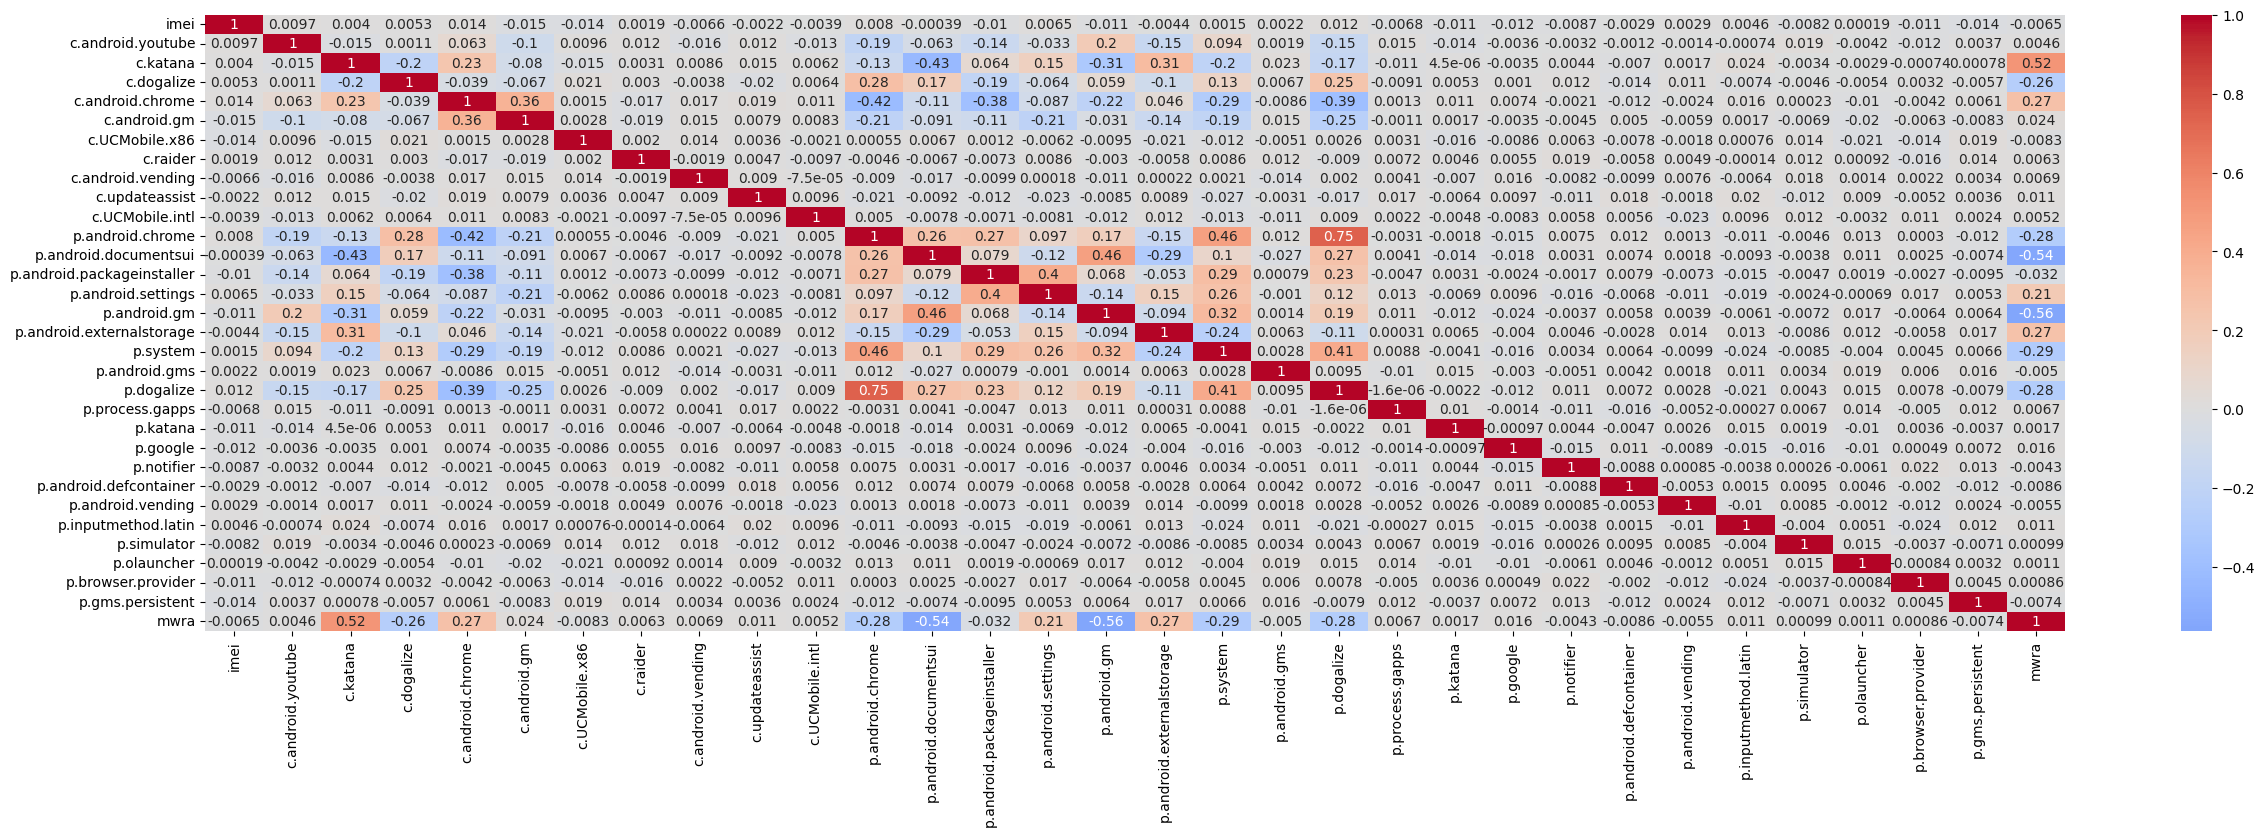

In [301]:
# Vytvorenie korelačnej matice
correlation_matrix = mp_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [302]:
# Výber korelácie pre cieľový stĺpec mwra a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie mwra zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

p.android.gm            -0.561503
p.android.documentsui   -0.544088
c.katana                 0.516967
p.system                -0.289418
p.android.chrome        -0.280080
Name: mwra, dtype: float64


# 2. technika Random Forest č.3

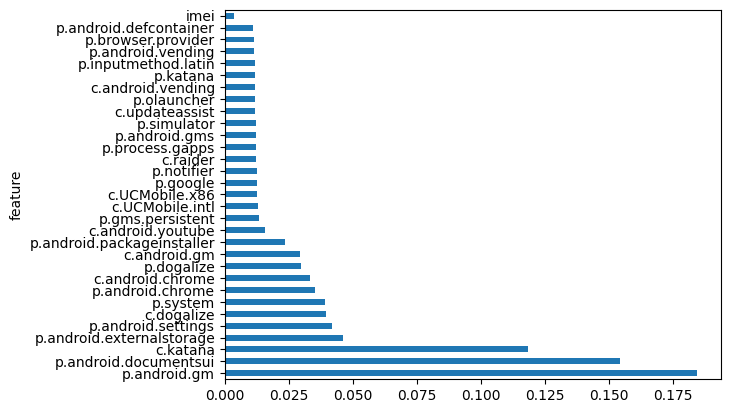

In [303]:
# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = mp_data.drop('mwra', axis=1)
y = mp_data['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

# 3. technika selektívne metóda s ANOVA č.3

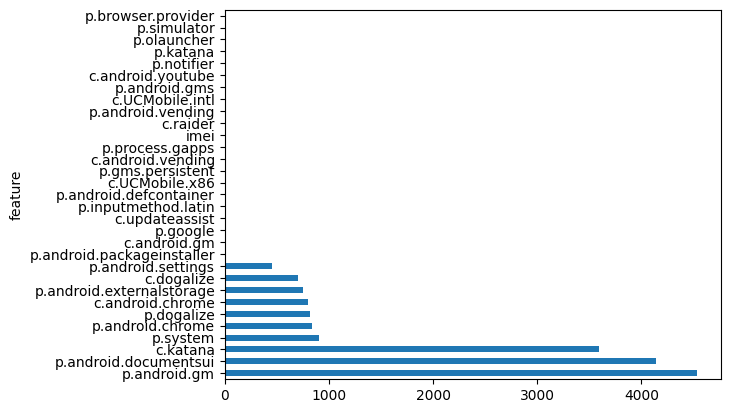

In [304]:
# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

In [305]:
importance_mp_df = get_importance_df(X, correlation_matrix, rf_model, selector)

# 4. dataframe MQ

# 1. technika Korelačná matica pre dataframe č. 4

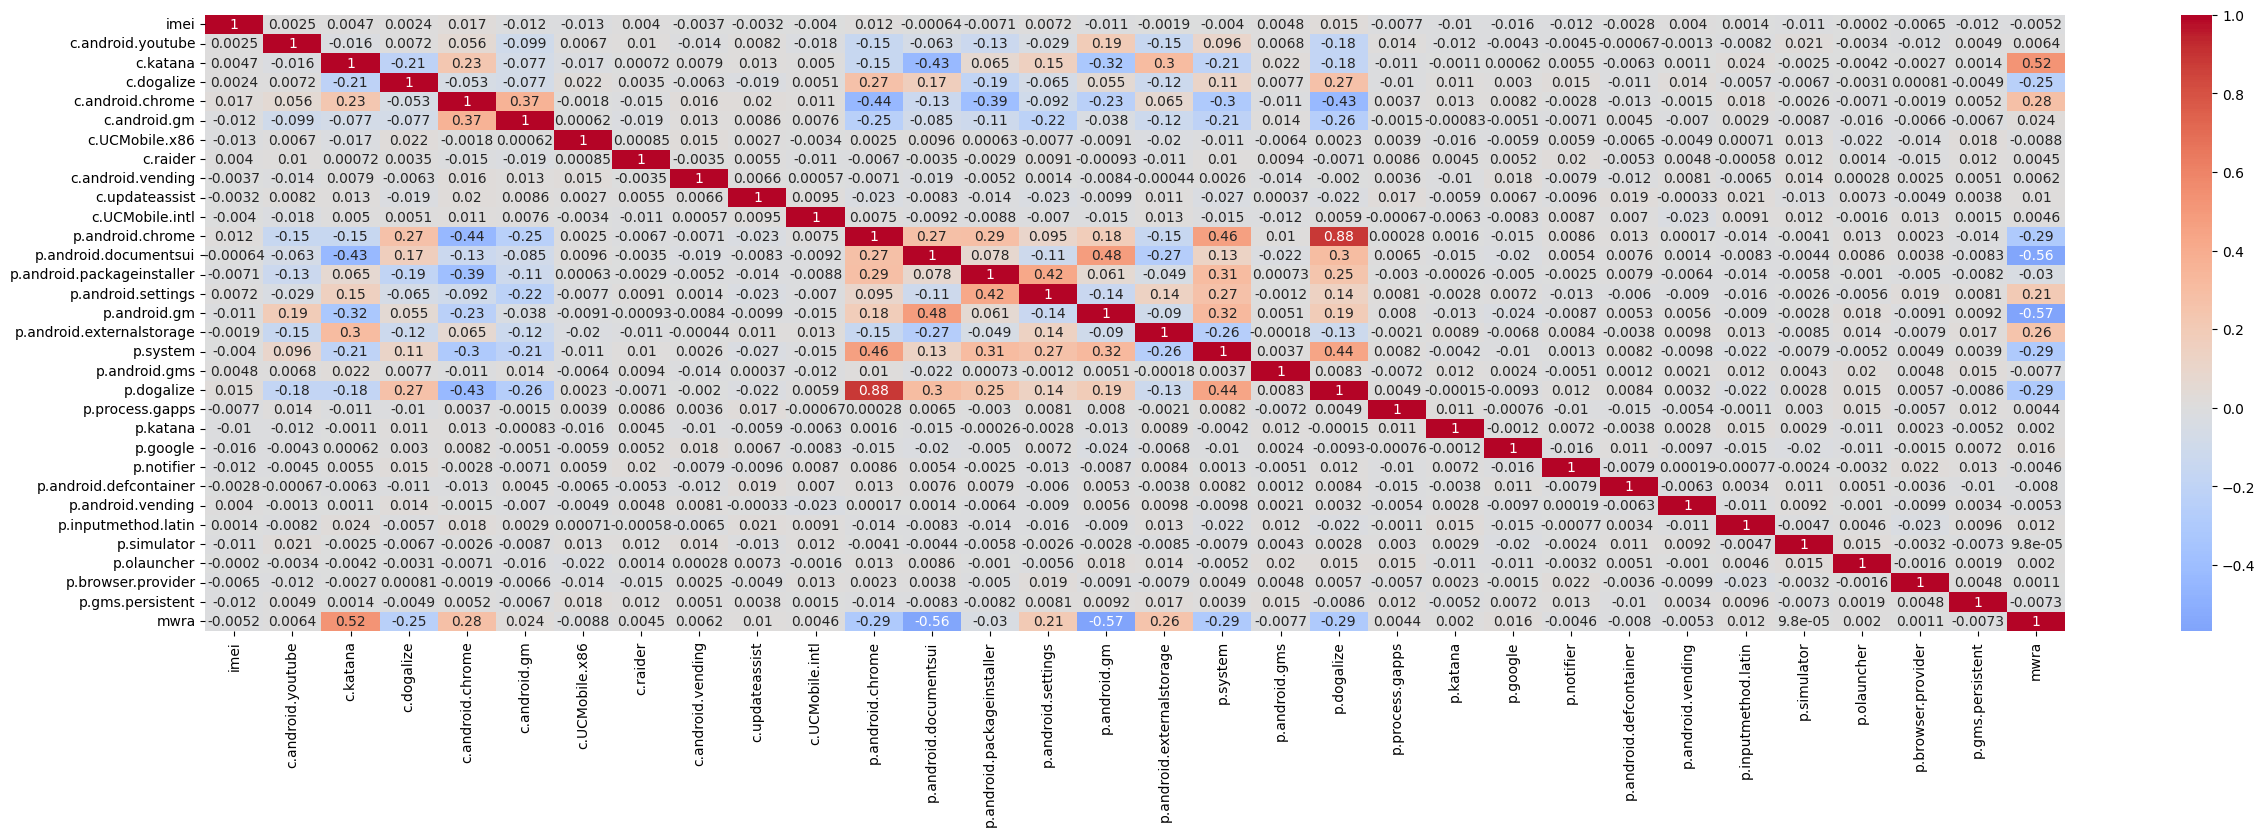

In [306]:
# Vytvorenie korelačnej matice
correlation_matrix = mq_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [307]:
# Výber korelácie pre cieľový stĺpec mwra a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie mwra zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

p.android.gm            -0.567521
p.android.documentsui   -0.559114
c.katana                 0.523234
p.dogalize              -0.293160
p.android.chrome        -0.292400
Name: mwra, dtype: float64


# 2. technika Random Forest č.4

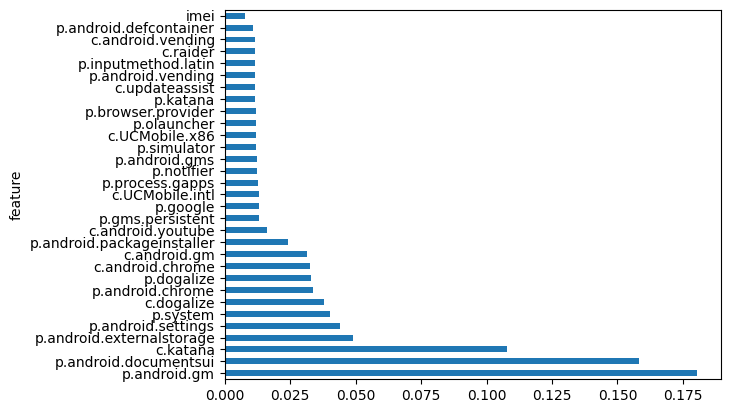

In [308]:
# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = mq_data.drop('mwra', axis=1)
y = mq_data['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

# 3. technika selektívne metóda s ANOVA č.4

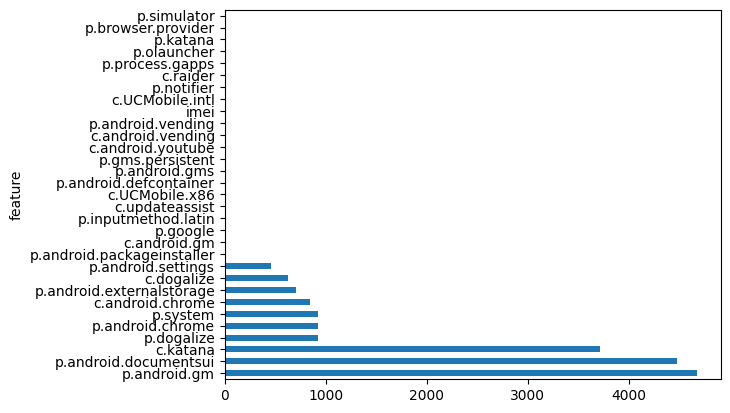

In [309]:
# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

In [310]:
importance_mq_df = get_importance_df(X, correlation_matrix, rf_model, selector)

- (B-1b) Zoraďte zistené atribúty v poradí podľa dôležitosti. 


# formalne hodnotenie dolezitosti atributov

Zoradíme atribúty podľa vypočítanej priemernej dôležitosti od najdôležitejších po najmenej dôležité. Tieto atribúty predstavujú finálny výber najinformatívnejších premenných.

pri korelacnej matici sme vybrali a videli top 5 atributov, uz pri tejto technike mozme vidiet rozdiel medzi top 3 a ostatnymi. Dalej nam to potvrdila technika Random forest aj SelectKBest Anova, ktore taktiez jasne indikuju ze prave 3 premenne najviac prispievaju a suvisia s predikciou mwra. rozdiel medzi 3. a 4. feature v poradi podla dolezitosti je o viac ako 50% v kazdom pripade. Rozhodli sme sa preto ze budeme brat do trenovanieho datasetu iba top 3 atributy.

In [311]:
# Zobrazenie výsledkov
print('Power transform + Standard scale')
print(importance_sp_df.sort_values(by='average_importance', ascending=False)[['feature', 'average_importance']].head(5))
print('Quantile transform + Standard scale')
print(importance_sq_df.sort_values(by='average_importance', ascending=False)[['feature', 'average_importance']].head(5))
print('Power transform + Min Max scale')
print(importance_mp_df.sort_values(by='average_importance', ascending=False)[['feature', 'average_importance']].head(5))
print('Quantile transform + Min Max scale')
print(importance_mq_df.sort_values(by='average_importance', ascending=False)[['feature', 'average_importance']].head(5))

Power transform + Standard scale
                      feature  average_importance
15               p.android.gm            1.000000
12      p.android.documentsui            0.906235
2                    c.katana            0.784762
17                   p.system            0.308948
16  p.android.externalstorage            0.297111
Quantile transform + Standard scale
                  feature  average_importance
15           p.android.gm            1.000000
12  p.android.documentsui            0.939832
2                c.katana            0.771019
17               p.system            0.311391
11       p.android.chrome            0.299868
Power transform + Min Max scale
                      feature  average_importance
15               p.android.gm            1.000000
12      p.android.documentsui            0.906235
2                    c.katana            0.784762
17                   p.system            0.308948
16  p.android.externalstorage            0.297111
Quantile transform + Mi

1. p.android.gm
2. p.android.documentsui
3. c.katana

Týmto spôsobom sme zoradili atribúty podľa ich dôležitosti pre cieľovú premennú. Atribúty s najvyšším skóre by mali byť zahrnuté v ďalšom modelovaní, pričom menej dôležité atribúty môžeme odstrániť alebo im prideliť nižšiu prioritu v ďalších analýzach.

### (C-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

# !!!!! TODO !!! TOTO ESTE SKONTROLOVAT ALEBO NEJAK PREPISAT VLASTNYMI SLOVAMI

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Výbere a Zoradení Atribútov

Pri výbere a zoradení atribútov sme použili rôzne metódy, aby sme zabezpečili robustnosť výsledkov a optimalizovali model pre predikciu. Nižšie sú uvedené hlavné dôvody výberu použitých techník a prístupu k zoradeniu atribútov.

## 1. Kombinácia Viacerých Techník pre Výber Atribútov
- **Dôvod**: Každá metóda výberu atribútov má svoje špecifiká a klady, a preto kombinácia viacerých techník znižuje riziko nesprávneho výberu a zvýrazňuje atribúty, ktoré sú konzistentne dôležité naprieč rôznymi metódami.
- **Prístup**: Použili sme korelačnú maticu, ktorá poskytuje intuitívny a rýchly prehľad o vzťahoch medzi atribútmi a cieľovou premennou. Random Forest a SelectKBest sme pridali, pretože poskytujú pokročilejšie metódy hodnotenia dôležitosti, pričom využívajú silné stránky štatistických testov a stromových algoritmov.

## 2. Normalizácia a Výpočet Priemernej Dôležitosti
- **Dôvod**: Každá metóda používa rôzne mierky dôležitosti, preto sme výsledky zjednotili cez normalizáciu, aby boli porovnateľné. Výpočet priemernej dôležitosti umožňuje kombinovať výsledky z rôznych metód do jedného koherentného skóre, čo nám dáva spoľahlivý základ na zoradenie atribútov.
- **Prístup**: Normalizované skóre každého atribútu z jednotlivých metód sme použili na výpočet priemernej dôležitosti. Táto metóda zaručuje, že naše konečné poradie nie je ovplyvnené extrémami v jednej z metód, a súčasne zohľadňuje viaceré aspekty dôležitosti.

## 3. Zoradenie Atribútov na základe Priemernej Dôležitosti
- **Dôvod**: Zoradenie podľa priemernej dôležitosti umožňuje zamerať sa na najvýznamnejšie atribúty pri vytváraní modelu, čo vedie k efektívnejšiemu a presnejšiemu modelu.
- **Výhoda pre model**: Zahrnutím najdôležitejších atribútov zvyšujeme presnosť modelu a znižujeme šum v dátach. Na základe tohto poradia môžeme rozhodnúť o odstránení menej dôležitých atribútov, čím znížime riziko nadmerného fitovania a zvýšime generalizovateľnosť modelu.

## Celkové Zdôvodnenie
Tieto rozhodnutia boli navrhnuté s cieľom optimalizovať efektívnosť a interpretabilitu modelu. Použitím viacerých techník a váženého prístupu sme sa snažili zaistiť, že výber atribútov nie je založený na jednej metóde, ale zohľadňuje rozmanité prístupy. Týmto spôsobom sme schopní presnejšie identifikovať najinformatívnejšie atribúty, čo je kľúčové pre dosiahnutie kvalitných výsledkov v ďalšej fáze modelovania.

## 2.3 Replikovateľnosť predspracovania (5b)

- (A-3b) Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť **na predspracovanie testovacej množiny** v kontexte strojového učenia.


In [312]:
def preprocesing(df, scaler, transformer):
    # vytvorenie copy aby sa nemodifikovali povodne data
    result_df = df.select_dtypes(include=[np.number]).copy()
    # prebehne preprocesing dataframu
    result_df = remove_duplicates(result_df)
    # missing values
    result_df = solve_missing_values(result_df)
    # outliers
    result_df = solve_outliers(result_df)
    # ulozenie predikovanej mwra
    saved_mwra = result_df['mwra'].reset_index(drop=True)
    result_df = result_df.drop(['mwra'], axis=1)
    # transform
    result_df = transformer.fit_transform(result_df)
    # scaling
    result_df = scaler.fit_transform(result_df)
    result_df = pd.DataFrame(result_df, columns=df.drop('mwra',axis=1).select_dtypes(include=[np.number]).columns)
    # Resetujeme index transformovaných dát pre konzistenciu
    result_df = result_df.reset_index(drop=True)
    # Pridame uložený stĺpec mwra späť do dátového rámca
    result_df['mwra'] = saved_mwra
    # return vyslednych preprocessed data
    return result_df

In [313]:
preprocessed_test_df = preprocesing(merged_test_df, scaler_min_max, power_transformer)

there are no missing values


/Users/filipzubaj/Desktop/School/IAU/iau_projekt/iau_project/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


<Axes: >

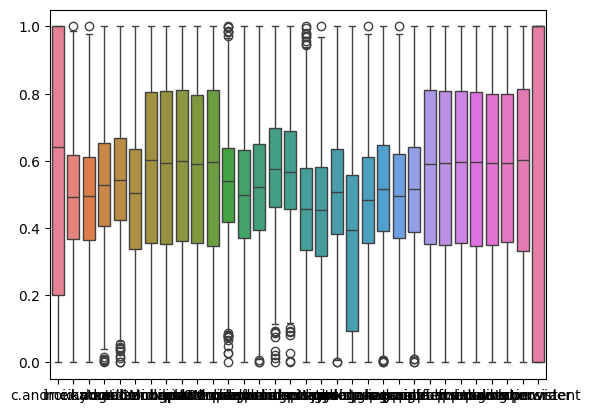

In [314]:
sns.boxplot(data=preprocessed_test_df)

- (B-2b) Využite možnosti **sklearn.pipeline**

In [319]:
# využijeme sklearn pipeline na vytvorenie pipeline, ktorá bude obsahovať všetko potrebné pre preprocessing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# aby sme mohli použiť pipeline, potrebujeme vytvoriť transformers

class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return remove_duplicates(X)
    
class SolveMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return solve_missing_values(X)

class SolveOutliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(sef, X, y=None):
        return solve_outliers(X)


train_data = merged_train_df.select_dtypes(include=[np.number]).copy()

# vytvorenie pipeline
preprocessing_pipeline = Pipeline([
    ('remove_duplicates', RemoveDuplicates()),
    ('solve_missing_values', SolveMissingValues()),
    ('solve_outliers', SolveOutliers()),
    ('transform', power_transformer),
    ('scale', scaler_min_max)
])

# spustenie pipeline na train data
preprocessed_train_data = preprocessing_pipeline.fit_transform(train_data)

there are no missing values


/Users/filipzubaj/Desktop/School/IAU/iau_projekt/iau_project/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


<Axes: >

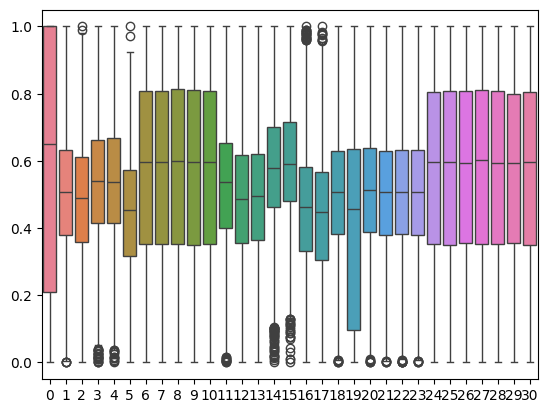

In [320]:
# zobrazenie pomocou boxplotu
sns.boxplot(data=preprocessed_train_data)